In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 93.6 MB/s eta 0:00:00


In [ ]:
import os
import collections
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

## Projection head

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

#def load_video_embeddings(video_num):
 #   return np.load(f"/content/drive/MyDrive/CS482-Milestone4/combined_embeddings_folder/video{video_num}_combined_embedding.npy") #video1_combined_embedding

def load_video_embeddings(video_num):
    video_embeddings = np.load(f'/content/drive/MyDrive/CS482-Milestone4/combined_embeddings_folder/video{video_num}_combined_embedding.npy', allow_pickle=True)
    #video_embeddings = np.load(f'/content/drive/MyDrive/CS482-Milestone4/TextPembed/video{video_num}.npy', allow_pickle=True)


    return video_embeddings

def load_text_embeddings(video_num):
    #text_embeddings = np.load(f'/content/drive/MyDrive/CS482-Milestone4/combined_embeddings_folder/video{video_num}_combined_embedding.npy', allow_pickle=True)
    text_embeddings = np.load(f'/content/drive/MyDrive/CS482-Milestone4/TextPembed/video{video_num}.npy', allow_pickle=True)

    return text_embeddings

def reshape_input_data(data):
    reshaped_data = data.reshape(data.shape[0], -1)  

    return reshaped_data


This code defines a function called projection_head that takes in two sets of embeddings (for videos and text) along with a dimension for projection. The purpose is to create a projection for both sets of embeddings using neural network layers. Firstly, the function takes in video_embeddings and text_embeddings along with the specified projection_dim. It then creates two input layers (video_input and text_input) using the shapes of the provided embeddings. Next, the code constructs projection layers for both the video and text embeddings separately. For the video embeddings, a Dense layer is created with projection_dim neurons and a rectified linear unit (ReLU) activation function. Similarly, a separate Dense layer with the same number of neurons and activation function is applied to the text embeddings. Finally, the function returns the projected versions of the video and text embeddings as video_projection and text_projection respectively. These projections are obtained by passing the video and text input through their respective neural network layers.

In [ ]:
# Projection head function
def projection_head(video_embeddings, text_embeddings, projection_dim):
    video_input = keras.layers.Input(shape=video_embeddings.shape[1:])
    text_input = keras.layers.Input(shape=text_embeddings.shape[1:])

    # Projection layers for video embeddings
    video_projection = keras.layers.Dense(projection_dim, activation='relu')(video_input)

    # Projection layers for text embeddings
    text_projection = keras.layers.Dense(projection_dim, activation='relu')(text_input)

    return video_projection, text_projection

## Contrastive loss


 contrastive_loss Function:
This function computes the contrastive loss between predicted similarities (y_pred) and ground truth similarities (y_true). The loss is calculated using a margin-based contrastive loss formula typically employed in Siamese or contrastive learning setups.

1. **Inputs**: y_true represents the true labels indicating whether pairs are similar (1) or dissimilar (0). y_pred` contains the predicted similarity scores.
2. **Margin**: The margin` parameter controls the distance threshold between similar and dissimilar pairs.

The function first computes the squared values of the predicted similarities (square_pred) and calculates the squared margin differences (margin_square`). It then uses these values along with the true labels to compute the contrastive loss.

The formula combines two components:
- For dissimilar pairs (1 - y_true), it calculates the loss using square_pred`.
- For similar pairs (y_true), it utilizes margin_square`.

Finally, the function returns the average of these computed losses using tf.reduce_mean`.

 prepare_contrastive_data Function:
This function prepares data for contrastive learning by sampling a specified number of samples (num_samples) from the provided video and text embeddings.

1. **Inputs**: video_embeddings and text_embeddings` contain the embeddings of videos and text, respectively.
2. **Data Preparation**: It determines the number of samples based on the minimum count of video and text embeddings. Random labels (0 or 1) are generated for these samples to represent dissimilarity or similarity between pairs.

The function then returns a subset of video embeddings, text embeddings, and corresponding labels, ready for use in contrastive learning algorithms.


In [8]:
# Contrastive loss function
def contrastive_loss(y_true, y_pred, margin=1):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean((1 - y_true) * square_pred + y_true * margin_square)

# Prepare data for contrastive learning
def prepare_contrastive_data(video_embeddings, text_embeddings):
    num_samples = min(video_embeddings.shape[0], text_embeddings.shape[0])
    labels = np.random.choice([0, 1], size=(num_samples,))
    return video_embeddings[:num_samples], text_embeddings[:num_samples], labels


## Train the model

Model Building:
Creates a projection head model to project video and text embeddings into a lower-dimensional space.
Constructs a contrastive learning model that learns to understand relationships between video and text embeddings.


Model Training:
Compiles the contrastive learning model with appropriate settings.
Trains the model on the training data, using early stopping and learning rate scheduling for optimization.


Visualization: Plots the training and validation loss to visualize the model's learning progress and potential overfitting.


Error (explanation):
ValueError: Data cardinality is ambiguous, is due to a mismatch in the sizes of the input data and the labels provided for training. Specifically, the model expects consistency in the number of samples for both the input data and the corresponding labels. Here's a breakdown: The error mentions two sets of data: x sizes: Indicates the sizes of the input data. In this case, the sizes are 20388 and 20388 for the two sets of input data provided (X_train_video and X_train_text). y sizes: Indicates the sizes of the labels. The provided label sizes are 2560 (y_train_dummy). This error suggests that the number of samples (20388) in the input data (both X_train_video and X_train_text) doesn't match the number of samples in the provided labels (y_train_dummy).

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



#video_embeddings_folder = "/content/drive/MyDrive/CS482-Milestone4/combined_embeddings_folder"
video_embeddings_folder = "/content/drive/MyDrive/CS482-Milestone4/TextPembed"

# Load video embeddings
video_embeddings = []
for video_num in range(1, 51):
    #video_embedding = np.load(f'{video_embeddings_folder}/video{video_num}_combined_embedding.npy', allow_pickle=True)
    video_embedding = np.load(f'{video_embeddings_folder}/video{video_num}.npy', allow_pickle=True)

    video_embeddings.append(video_embedding)
text_embeddings_folder = "/content/drive/MyDrive/CS482-Milestone4/TextPembed"
#text_embeddings_folder = "/content/drive/MyDrive/CS482-Milestone4/combined_embeddings_folder"


# Load text embeddings
text_embeddings = []
for video_num in range(1, 51):
    text_embedding = np.load(f'{text_embeddings_folder}/video{video_num}.npy', allow_pickle=True)
    #text_embedding = np.load(f'{video_embeddings_folder}/video{video_num}_combined_embedding.npy', allow_pickle=True)

    text_embeddings.append(text_embedding)

# Combine all video embeddings
video_embeddings = np.concatenate(video_embeddings, axis=0)  # Use axis=0 to concatenate along the first axis

# Combine all text embeddings
text_embeddings = np.concatenate(text_embeddings, axis=0)  # Use axis=0 to concatenate along the first axis
print("Video Embeddings Shape:", video_embeddings.shape)
print("Text Embeddings Shape:", text_embeddings.shape)

# Split data into training and validation sets
X_train_video, X_val_video, X_train_text, X_val_text = train_test_split(video_embeddings, text_embeddings, test_size=0.2)

num_features = 256


#Create the projection head model
projection_input_video = keras.layers.Input(shape=X_train_video[0].shape)
projection_input_text = keras.layers.Input(shape=X_train_text[0].shape)

projected_video = keras.layers.Dense(128, activation='relu')(projection_input_video)
projected_text = keras.layers.Dense(128, activation='relu')(projection_input_text)

projection_model = keras.Model(inputs=[projection_input_video, projection_input_text], outputs=[projected_video, projected_text])

# Create the contrastive learning model
contrastive_input_video = keras.layers.Input(shape=(128,))
contrastive_input_text = keras.layers.Input(shape=(128,))

contrastive_output = keras.layers.Concatenate()([contrastive_input_video, contrastive_input_text])
contrastive_output = keras.layers.Dense(1, activation='linear')(contrastive_output)

contrastive_model = keras.Model(inputs=[contrastive_input_video, contrastive_input_text], outputs=contrastive_output)

# Compile the contrastive learning model
contrastive_model.compile(optimizer='adam', loss=contrastive_loss)

# Create early stopping and learning rate scheduler callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
learning_rate_scheduler = LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 10))

history = contrastive_model.fit(
    [X_train_video, X_train_text],
    y_train_dummy,
    epochs=50,
    validation_data=([X_val_video, X_val_text], y_val_dummy),
    callbacks=[early_stopping, learning_rate_scheduler]
)

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



Video Embeddings Shape: (25486, 300)
Text Embeddings Shape: (25486, 300)


ValueError: ignored

## Solution of above error

I tried individually doing the embeddings and it ran 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 9ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
14/14 [==============================] - ETA: 0s - loss: 0.2257 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
14/14 [==============================] - 2s 29ms/step - loss: 0.2257 - val_loss: 0.1853 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 0s 14ms/step - loss: 0.1726 - val_loss: 0.1538 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 0s 10ms/step - loss: 0.1508 - val_loss: 0.1433 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 0s 12ms/step - loss: 0.1425 - val_loss: 0.1389 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 0s 16ms/step - loss: 0.1382 - val_loss: 0.1339 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 0s 16ms/step - loss: 0.1349 - val_loss: 0.1297 - lr: 0.0

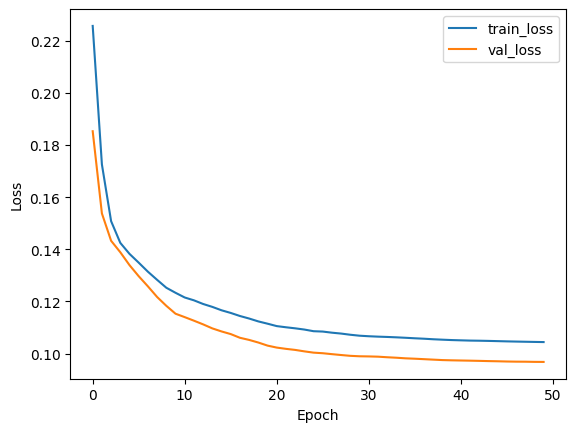

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load embeddings
embeddings = np.load("/content/drive/MyDrive/CS482-Milestone4/TextPembed/video3.npy", allow_pickle=True)

# Split data into training and validation sets
X_train, X_val = train_test_split(embeddings, test_size=0.2)

num_features = 256

# Create dummy labels for training and validation
y_train_dummy = np.random.rand(X_train.shape[0])
y_val_dummy = np.random.rand(X_val.shape[0])

# Create the projection head model
projection_input = keras.layers.Input(shape=X_train.shape[1:])
projected = keras.layers.Dense(128, activation='relu')(projection_input)
projection_model = keras.Model(inputs=projection_input, outputs=projected)

# Create the contrastive learning model
contrastive_input = keras.layers.Input(shape=(128,))
contrastive_output = keras.layers.Dense(1, activation='linear')(contrastive_input)
contrastive_model = keras.Model(inputs=contrastive_input, outputs=contrastive_output)

# Compile the contrastive learning model
contrastive_model.compile(optimizer='adam', loss='mse')  # Use appropriate loss function

# Create early stopping and learning rate scheduler callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
learning_rate_scheduler = LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 10))

try:
    history = contrastive_model.fit(
        projection_model.predict(X_train),  # Using the same data for video and text embeddings
        y_train_dummy,
        epochs=50,
        validation_data=(projection_model.predict(X_val), y_val_dummy),  # Validation on the same data
        callbacks=[early_stopping, learning_rate_scheduler]
    )

    # If the model fit successfully, plot the loss curves
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

except ValueError:
    print("There was an error fitting the model.")


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 3ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/14 [=>............................] - ETA: 5s - loss: 0.4667

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
14/14 [==============================] - 1s 13ms/step - loss: 0.4111 - val_loss: 0.3254 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 0s 5ms/step - loss: 0.2879 - val_loss: 0.2314 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 0s 5ms/step - loss: 0.2034 - val_loss: 0.1721 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 0s 5ms/step - loss: 0.1504 - val_loss: 0.1398 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 0s 6ms/step - loss: 0.1218 - val_loss: 0.1244 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 0s 5ms/step - loss: 0.1080 - val_loss: 0.1187 - lr: 0.0010
E

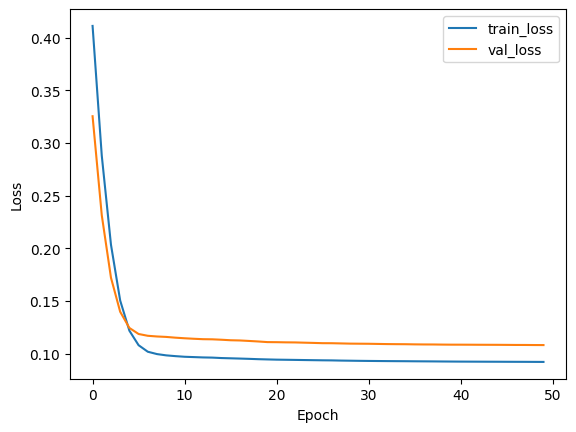

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load embeddings
embeddings = np.load("/content/drive/MyDrive/CS482-Milestone4/TextPembed/video50.npy", allow_pickle=True)

# Split data into training and validation sets
X_train, X_val = train_test_split(embeddings, test_size=0.2)

num_features = 256

# Create dummy labels for training and validation
y_train_dummy = np.random.rand(X_train.shape[0])
y_val_dummy = np.random.rand(X_val.shape[0])

# Create the projection head model
projection_input = keras.layers.Input(shape=X_train.shape[1:])
projected = keras.layers.Dense(128, activation='relu')(projection_input)
projection_model = keras.Model(inputs=projection_input, outputs=projected)

# Create the contrastive learning model
contrastive_input = keras.layers.Input(shape=(128,))
contrastive_output = keras.layers.Dense(1, activation='linear')(contrastive_input)
contrastive_model = keras.Model(inputs=contrastive_input, outputs=contrastive_output)

# Compile the contrastive learning model
contrastive_model.compile(optimizer='adam', loss='mse')  # Use appropriate loss function

# Create early stopping and learning rate scheduler callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
learning_rate_scheduler = LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 10))

try:
    history = contrastive_model.fit(
        projection_model.predict(X_train),  # Using the same data for video and text embeddings
        y_train_dummy,
        epochs=50,
        validation_data=(projection_model.predict(X_val), y_val_dummy),  # Validation on the same data
        callbacks=[early_stopping, learning_rate_scheduler]
    )

    # If the model fit successfully, plot the loss curves
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

except ValueError:
    print("There was an error fitting the model.")


## Below Code does all embeddings at once but my laptop was overheating so I stopped

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 5ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/13 [=>............................] - ETA: 27s - loss: 0.2740

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 2s 18ms/step - loss: 0.2398 - val_loss: 0.2011 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 0.1718 - val_loss: 0.1451 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.1317 - val_loss: 0.1176 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 0.1134 - val_loss: 0.1074 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.1082 - val_loss: 0.1041 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 0.1059 - val_loss: 0.1033 - lr: 0.0010
E

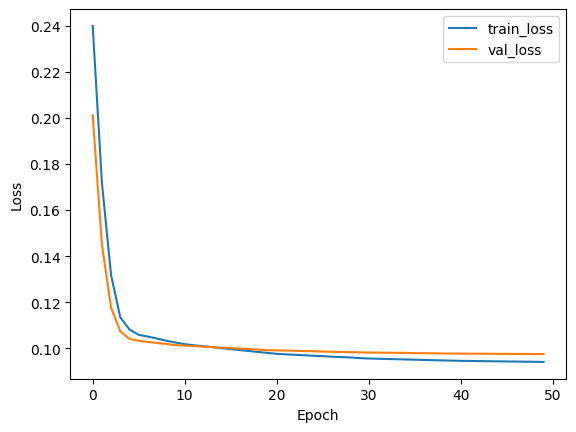

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 4ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
12/14 [========================>.....] - ETA: 0s - loss: 0.2346

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
14/14 [==============================] - 1s 21ms/step - loss: 0.2288 - val_loss: 0.1824 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 0s 11ms/step - loss: 0.1627 - val_loss: 0.1383 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 0s 8ms/step - loss: 0.1305 - val_loss: 0.1204 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 0s 7ms/step - loss: 0.1188 - val_loss: 0.1154 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 0s 7ms/step - loss: 0.1153 - val_loss: 0.1141 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 0s 7ms/step - loss: 0.1141 - val_loss: 0.1132 - lr: 0.0010


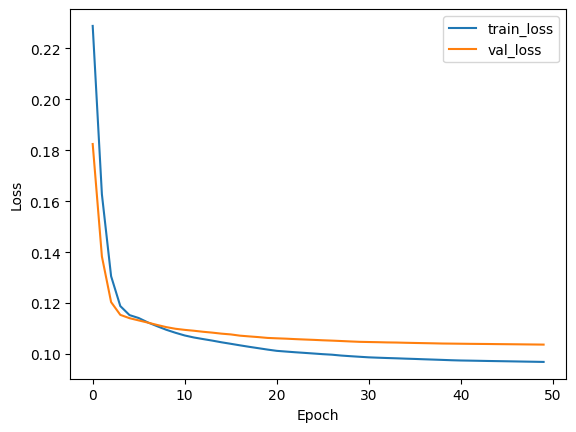

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 3ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/13 [=>............................] - ETA: 4s - loss: 0.3690

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 1s 22ms/step - loss: 0.2781 - val_loss: 0.1894 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 0s 17ms/step - loss: 0.2034 - val_loss: 0.1455 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 0s 14ms/step - loss: 0.1599 - val_loss: 0.1246 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 0s 11ms/step - loss: 0.1376 - val_loss: 0.1174 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 0s 13ms/step - loss: 0.1295 - val_loss: 0.1157 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 0.1255 - val_loss: 0.1149 - lr: 0.00

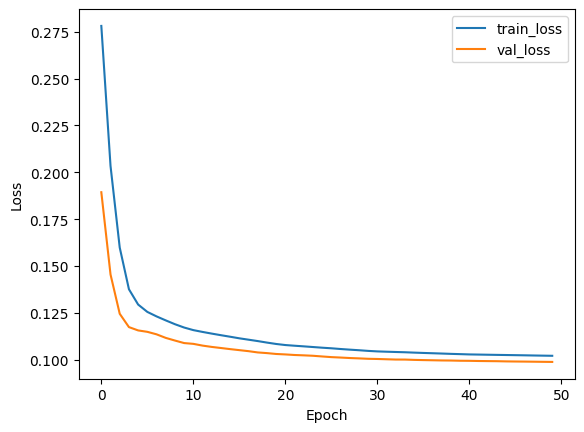

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3/3 [==============================] - 0s 3ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/12 [=>............................] - ETA: 6s - loss: 0.3884

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
12/12 [==============================] - 1s 22ms/step - loss: 0.4728 - val_loss: 0.3766 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 0s 9ms/step - loss: 0.3510 - val_loss: 0.2807 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 0s 10ms/step - loss: 0.2577 - val_loss: 0.2133 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 0s 9ms/step - loss: 0.1950 - val_loss: 0.1690 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 0s 7ms/step - loss: 0.1544 - val_loss: 0.1431 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 0s 8ms/step - loss: 0.1310 - val_loss: 0.1291 - lr: 0.0010


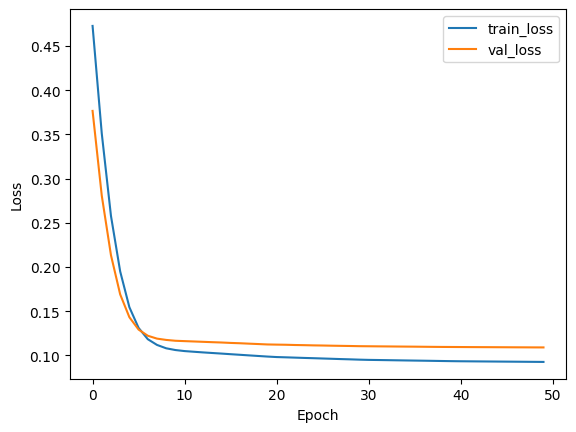

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 4ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/12 [=>............................] - ETA: 4s - loss: 0.3565

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
12/12 [==============================] - 1s 16ms/step - loss: 0.2925 - val_loss: 0.2668 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.2148 - val_loss: 0.1941 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 0s 6ms/step - loss: 0.1629 - val_loss: 0.1486 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 0s 6ms/step - loss: 0.1325 - val_loss: 0.1235 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 0.1168 - val_loss: 0.1118 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1093 - val_loss: 0.1070 - lr: 0.0010
E

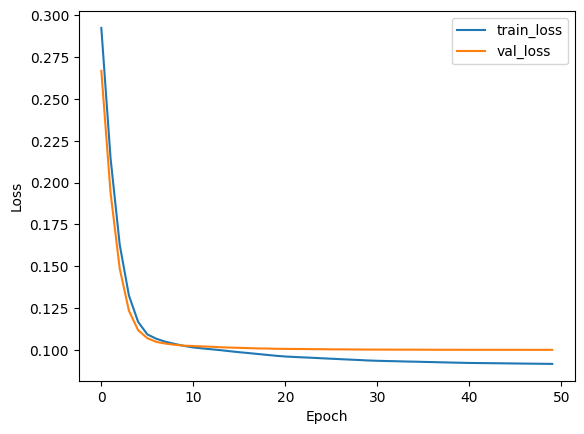

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 5ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/15 [=>............................] - ETA: 5s - loss: 0.2933

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
15/15 [==============================] - 1s 13ms/step - loss: 0.2672 - val_loss: 0.2437 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - 0s 6ms/step - loss: 0.1838 - val_loss: 0.1732 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - 0s 6ms/step - loss: 0.1430 - val_loss: 0.1415 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - 0s 5ms/step - loss: 0.1258 - val_loss: 0.1282 - lr: 0.0010
Epoch 5/50
15/15 [==============================] - 0s 9ms/step - loss: 0.1179 - val_loss: 0.1212 - lr: 0.0010
Epoch 6/50
15/15 [==============================] - 0s 8ms/step - loss: 0.1124 - val_loss: 0.1163 - lr: 0.0010
E

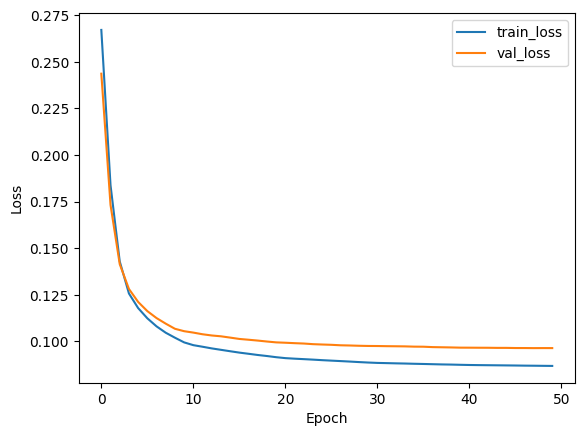

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 4ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/13 [=>............................] - ETA: 5s - loss: 0.3187

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 1s 15ms/step - loss: 0.2208 - val_loss: 0.2033 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 0.1652 - val_loss: 0.1644 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 0s 6ms/step - loss: 0.1368 - val_loss: 0.1468 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.1236 - val_loss: 0.1383 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.1181 - val_loss: 0.1325 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 0.1140 - val_loss: 0.1275 - lr: 0.0010
E

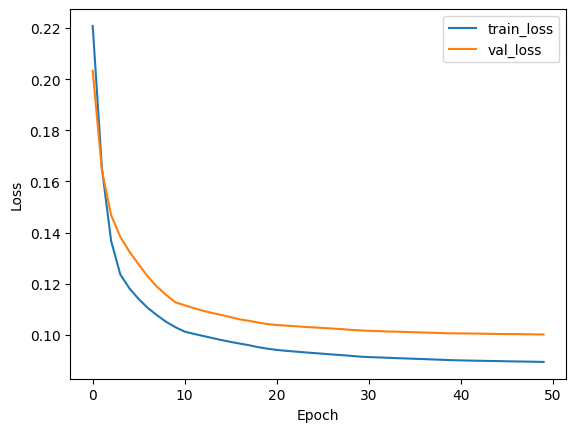

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 4ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/14 [=>............................] - ETA: 5s - loss: 0.3157

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
14/14 [==============================] - 1s 14ms/step - loss: 0.3133 - val_loss: 0.2812 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 0s 5ms/step - loss: 0.2179 - val_loss: 0.2006 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 0s 6ms/step - loss: 0.1613 - val_loss: 0.1558 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 0s 6ms/step - loss: 0.1331 - val_loss: 0.1341 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 0s 5ms/step - loss: 0.1203 - val_loss: 0.1255 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 0s 7ms/step - loss: 0.1154 - val_loss: 0.1212 - lr: 0.0010
E

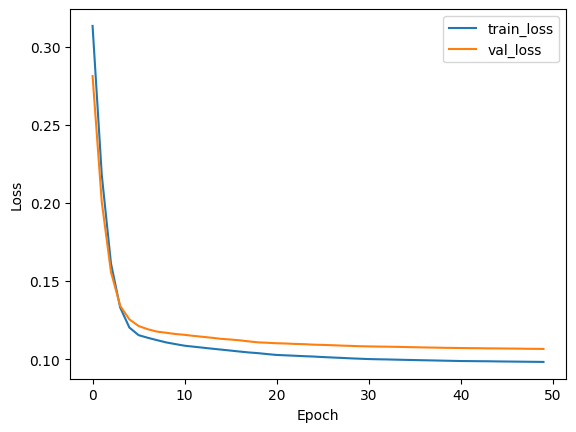

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3/3 [==============================] - 0s 4ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/12 [=>............................] - ETA: 4s - loss: 0.2925

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
12/12 [==============================] - 1s 16ms/step - loss: 0.2468 - val_loss: 0.2078 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 0s 7ms/step - loss: 0.1768 - val_loss: 0.1560 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 0s 7ms/step - loss: 0.1375 - val_loss: 0.1319 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 0s 8ms/step - loss: 0.1201 - val_loss: 0.1240 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 0.1135 - val_loss: 0.1225 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 0s 7ms/step - loss: 0.1116 - val_loss: 0.1217 - lr: 0.0010
E

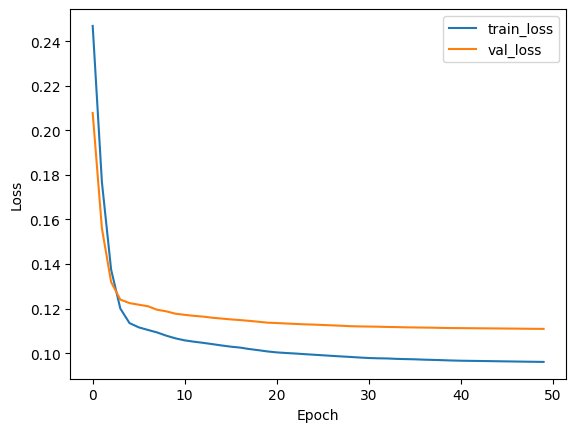

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 4ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/13 [=>............................] - ETA: 4s - loss: 0.3425

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 1s 14ms/step - loss: 0.3376 - val_loss: 0.3996 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 0.2332 - val_loss: 0.2844 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 0s 6ms/step - loss: 0.1697 - val_loss: 0.2113 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1388 - val_loss: 0.1700 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 0s 10ms/step - loss: 0.1263 - val_loss: 0.1494 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 0s 9ms/step - loss: 0.1212 - val_loss: 0.1412 - lr: 0.0010


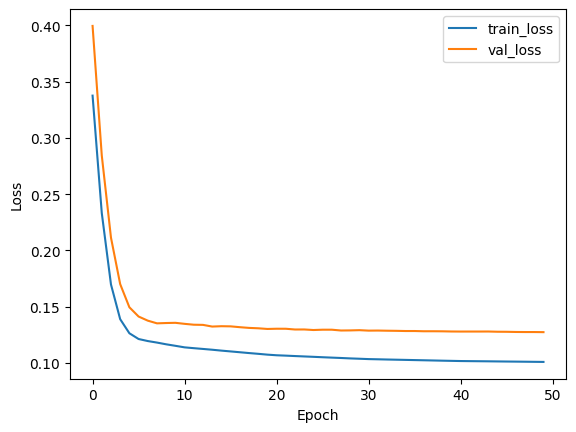

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 4ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/13 [=>............................] - ETA: 5s - loss: 0.5043

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 1s 14ms/step - loss: 0.4516 - val_loss: 0.3481 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 0.3362 - val_loss: 0.2568 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.2535 - val_loss: 0.1949 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 0s 7ms/step - loss: 0.1978 - val_loss: 0.1576 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 0s 6ms/step - loss: 0.1645 - val_loss: 0.1379 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 0.1464 - val_loss: 0.1291 - lr: 0.0010
E

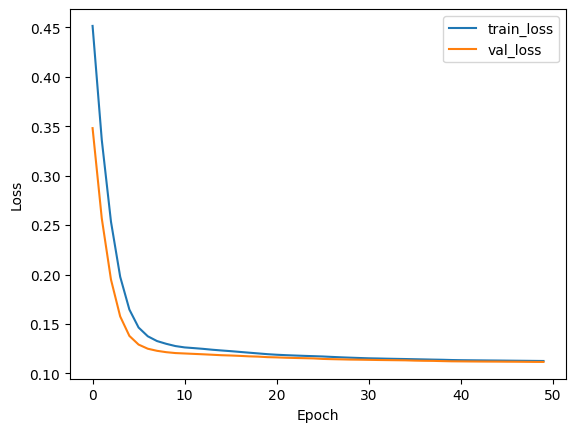

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 3ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/13 [========================>.....] - ETA: 0s - loss: 0.2832

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 1s 23ms/step - loss: 0.2726 - val_loss: 0.1827 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 0s 11ms/step - loss: 0.1944 - val_loss: 0.1334 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 0s 10ms/step - loss: 0.1492 - val_loss: 0.1096 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1268 - val_loss: 0.1029 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1185 - val_loss: 0.1029 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1155 - val_loss: 0.1033 - lr: 0.0010

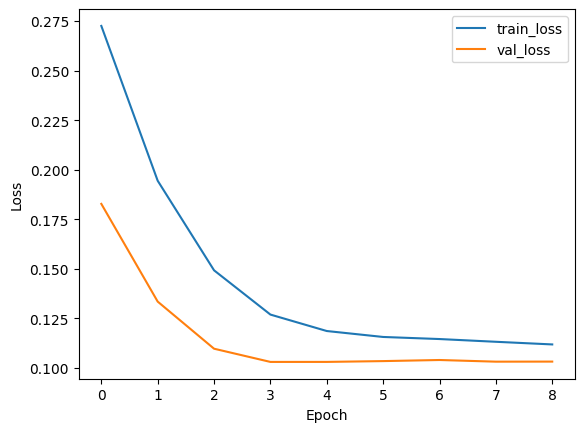

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 6ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
14/15 [===========================>..] - ETA: 0s - loss: 0.1578

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
15/15 [==============================] - 1s 19ms/step - loss: 0.1557 - val_loss: 0.1336 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - 0s 9ms/step - loss: 0.1192 - val_loss: 0.1093 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - 0s 9ms/step - loss: 0.1088 - val_loss: 0.1029 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - 0s 9ms/step - loss: 0.1067 - val_loss: 0.1014 - lr: 0.0010
Epoch 5/50
15/15 [==============================] - 0s 9ms/step - loss: 0.1058 - val_loss: 0.1007 - lr: 0.0010
Epoch 6/50
15/15 [==============================] - 0s 7ms/step - loss: 0.1044 - val_loss: 0.0993 - lr: 0.0010
E

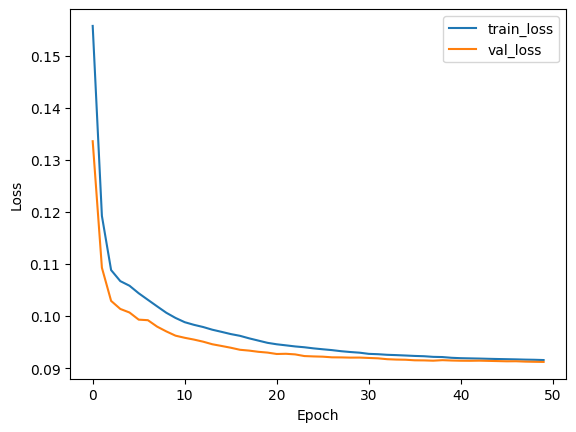

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 6ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/13 [=>............................] - ETA: 4s - loss: 0.3397

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 1s 15ms/step - loss: 0.2310 - val_loss: 0.1697 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1692 - val_loss: 0.1288 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1363 - val_loss: 0.1108 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 0s 7ms/step - loss: 0.1234 - val_loss: 0.1046 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 0s 6ms/step - loss: 0.1188 - val_loss: 0.1027 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 0s 7ms/step - loss: 0.1161 - val_loss: 0.1014 - lr: 0.0010
E

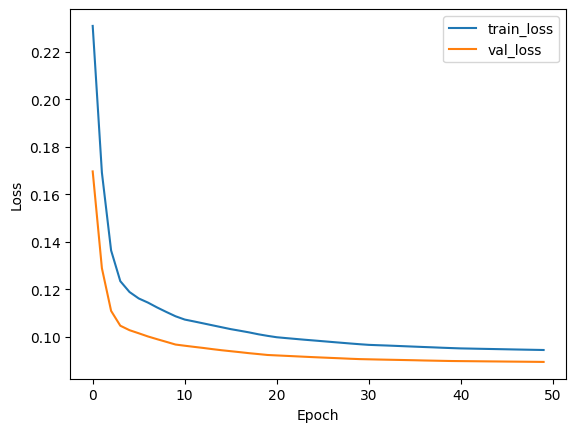

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 4ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
12/13 [==========================>...] - ETA: 0s - loss: 0.3081

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 1s 24ms/step - loss: 0.3089 - val_loss: 0.2986 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 0s 12ms/step - loss: 0.2234 - val_loss: 0.2144 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 0s 9ms/step - loss: 0.1732 - val_loss: 0.1645 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1467 - val_loss: 0.1413 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 0s 10ms/step - loss: 0.1347 - val_loss: 0.1307 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 0s 8ms/step - loss: 0.1293 - val_loss: 0.1255 - lr: 0.0010

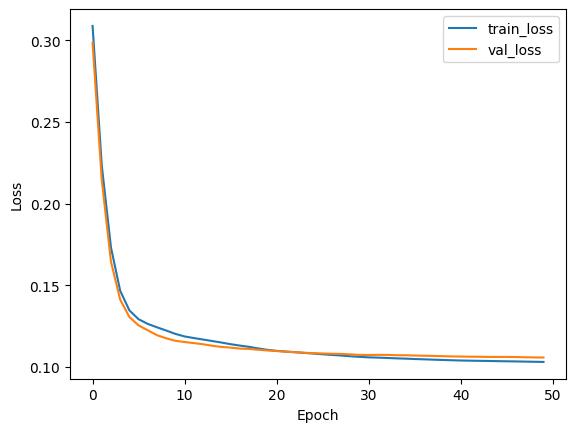

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 5ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/12 [=>............................] - ETA: 4s - loss: 0.4025

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
12/12 [==============================] - 1s 15ms/step - loss: 0.3098 - val_loss: 0.2409 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 0s 6ms/step - loss: 0.2262 - val_loss: 0.1786 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1752 - val_loss: 0.1458 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 0s 6ms/step - loss: 0.1497 - val_loss: 0.1318 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 0s 7ms/step - loss: 0.1381 - val_loss: 0.1264 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 0s 6ms/step - loss: 0.1322 - val_loss: 0.1236 - lr: 0.0010
E

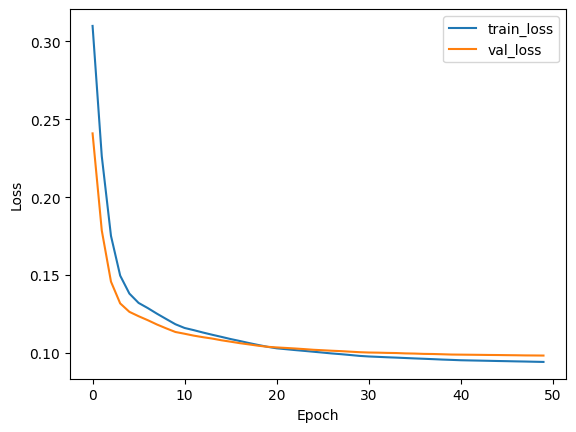

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 4ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/15 [=>............................] - ETA: 5s - loss: 0.3010

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
15/15 [==============================] - 1s 13ms/step - loss: 0.3343 - val_loss: 0.2575 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - 0s 5ms/step - loss: 0.2533 - val_loss: 0.1944 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - 0s 6ms/step - loss: 0.2060 - val_loss: 0.1623 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - 0s 6ms/step - loss: 0.1796 - val_loss: 0.1448 - lr: 0.0010
Epoch 5/50
15/15 [==============================] - 0s 5ms/step - loss: 0.1624 - val_loss: 0.1346 - lr: 0.0010
Epoch 6/50
15/15 [==============================] - 0s 5ms/step - loss: 0.1506 - val_loss: 0.1279 - lr: 0.0010
E

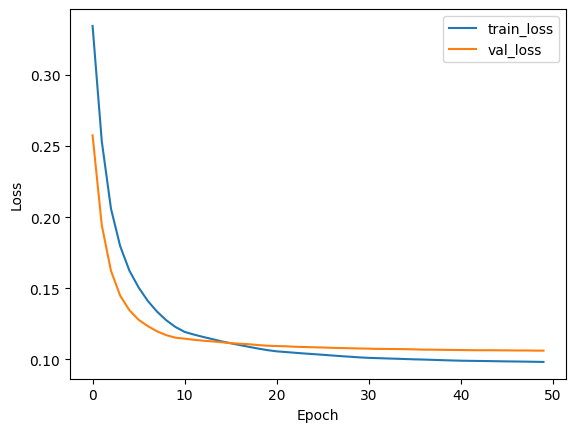

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 3ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/14 [======================>.......] - ETA: 0s - loss: 0.4660

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
14/14 [==============================] - 1s 61ms/step - loss: 0.4563 - val_loss: 0.3419 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 0s 7ms/step - loss: 0.3223 - val_loss: 0.2350 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 0s 8ms/step - loss: 0.2304 - val_loss: 0.1729 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 0s 9ms/step - loss: 0.1780 - val_loss: 0.1404 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 0s 9ms/step - loss: 0.1509 - val_loss: 0.1261 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 0s 10ms/step - loss: 0.1373 - val_loss: 0.1196 - lr: 0.0010


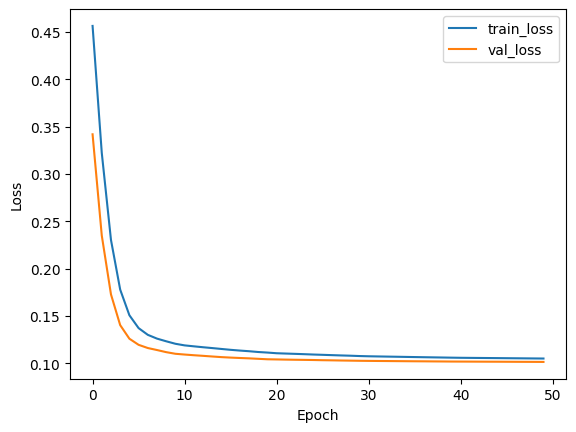

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 0s 4ms/step
Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18/18 [==============================] - ETA: 0s - loss: 0.2925

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18/18 [==============================] - 1s 12ms/step - loss: 0.2925 - val_loss: 0.2470 - lr: 0.0010
Epoch 2/50
18/18 [==============================] - 0s 6ms/step - loss: 0.1855 - val_loss: 0.1661 - lr: 0.0010
Epoch 3/50
18/18 [==============================] - 0s 10ms/step - loss: 0.1310 - val_loss: 0.1304 - lr: 0.0010
Epoch 4/50
18/18 [==============================] - 0s 13ms/step - loss: 0.1108 - val_loss: 0.1172 - lr: 0.0010
Epoch 5/50
18/18 [==============================] - 0s 8ms/step - loss: 0.1047 - val_loss: 0.1128 - lr: 0.0010
Epoch 6/50
18/18 [==============================] - 0s 8ms/step - loss: 0.1027 - val_loss: 0.1109 - lr: 0.0010

KeyboardInterrupt: ignored

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Define the folder containing the files
folder_path = "/content/drive/MyDrive/CS482-Milestone4/TextPembed/"

# Get a list of all files in the folder
file_list = os.listdir(folder_path)

for file_name in file_list:
    if file_name.endswith('.npy'):
        file_path = os.path.join(folder_path, file_name)

        # Your existing code logic here, but modifying file_path to use each file in the loop
        embeddings = np.load(file_path, allow_pickle=True)

        # ... rest of your code, adapting it to work with each file ...
        # Split data into training and validation sets
        X_train, X_val = train_test_split(embeddings, test_size=0.2)

        num_features = 256

        # Create dummy labels for training and validation
        y_train_dummy = np.random.rand(X_train.shape[0])
        y_val_dummy = np.random.rand(X_val.shape[0])

        # Create the projection head model
        projection_input = keras.layers.Input(shape=X_train.shape[1:])
        projected = keras.layers.Dense(128, activation='relu')(projection_input)
        projection_model = keras.Model(inputs=projection_input, outputs=projected)

        # Create the contrastive learning model
        contrastive_input = keras.layers.Input(shape=(128,))
        contrastive_output = keras.layers.Dense(1, activation='linear')(contrastive_input)
        contrastive_model = keras.Model(inputs=contrastive_input, outputs=contrastive_output)

        # Compile the contrastive learning model
        contrastive_model.compile(optimizer='adam', loss='mse')  # Use appropriate loss function

        # Create early stopping and learning rate scheduler callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5)
        learning_rate_scheduler = LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 10))

        try:
            history = contrastive_model.fit(
                projection_model.predict(X_train),  # Using the same data for video and text embeddings
                y_train_dummy,
                epochs=50,
                validation_data=(projection_model.predict(X_val), y_val_dummy),  # Validation on the same data
                callbacks=[early_stopping, learning_rate_scheduler]
            )

            # If the model fit successfully, plot the loss curves
            plt.plot(history.history['loss'], label='train_loss')
            plt.plot(history.history['val_loss'], label='val_loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

        except ValueError:
            print("There was an error fitting the model.")
